In [30]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import uproot

1.13.1


In [2]:
file = uproot.open("pid.root")

In [3]:
file.keys()
tree = file["PidTuple"]
tree.keys()

[b'mom',
 b'theta',
 b'svt',
 b'emc',
 b'drc',
 b'dch',
 b'ifr',
 b'ifrExp',
 b'ifrAdd',
 b'ifrStrip',
 b'ifrFirst',
 b'ifrLast',
 b'emcS1S9',
 b'emcS9S25',
 b'emczern20',
 b'emczern40',
 b'emclat',
 b'charge',
 b'drcnphot',
 b'emcphi',
 b'emctheta',
 b'pid',
 b'lipisvt',
 b'limusvt',
 b'likasvt',
 b'lipidch',
 b'limudch',
 b'likadch',
 b'lipidrc',
 b'limudrc',
 b'likadrc',
 b'lipiemc',
 b'limuemc',
 b'likaemc',
 b'lipiifr',
 b'limuifr',
 b'likaifr']

In [4]:
tree["mom"].array()

array([1.5605692, 1.5410209, 1.4362378, ..., 1.8818983, 1.9985647,
       0.9953289], dtype=float32)

In [40]:
data = tree.arrays(["mom", "theta", "svt", "emc", "drc", "dch", "ifr", "pid"])

In [55]:
dataset = pd.DataFrame(data)

In [56]:
dataset.tail()

,b'mom',b'theta',b'svt',b'emc',b'drc',b'dch',b'ifr',b'pid'
83821,1.156832,0.842868,5.810547,0.365639,0.495674,732.421875,0.000000,5.0
83822,2.320551,0.914929,4.296875,1.259613,0.749020,537.109375,0.000000,5.0
83823,1.881898,0.807030,4.589844,0.164413,0.710582,454.101562,2.352941,5.0
83824,1.998565,0.996907,3.564453,0.463104,0.721126,444.335938,3.019608,5.0
83825,0.995329,0.923367,6.005859,0.354385,0.364935,771.484375,0.000000,5.0


In [15]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

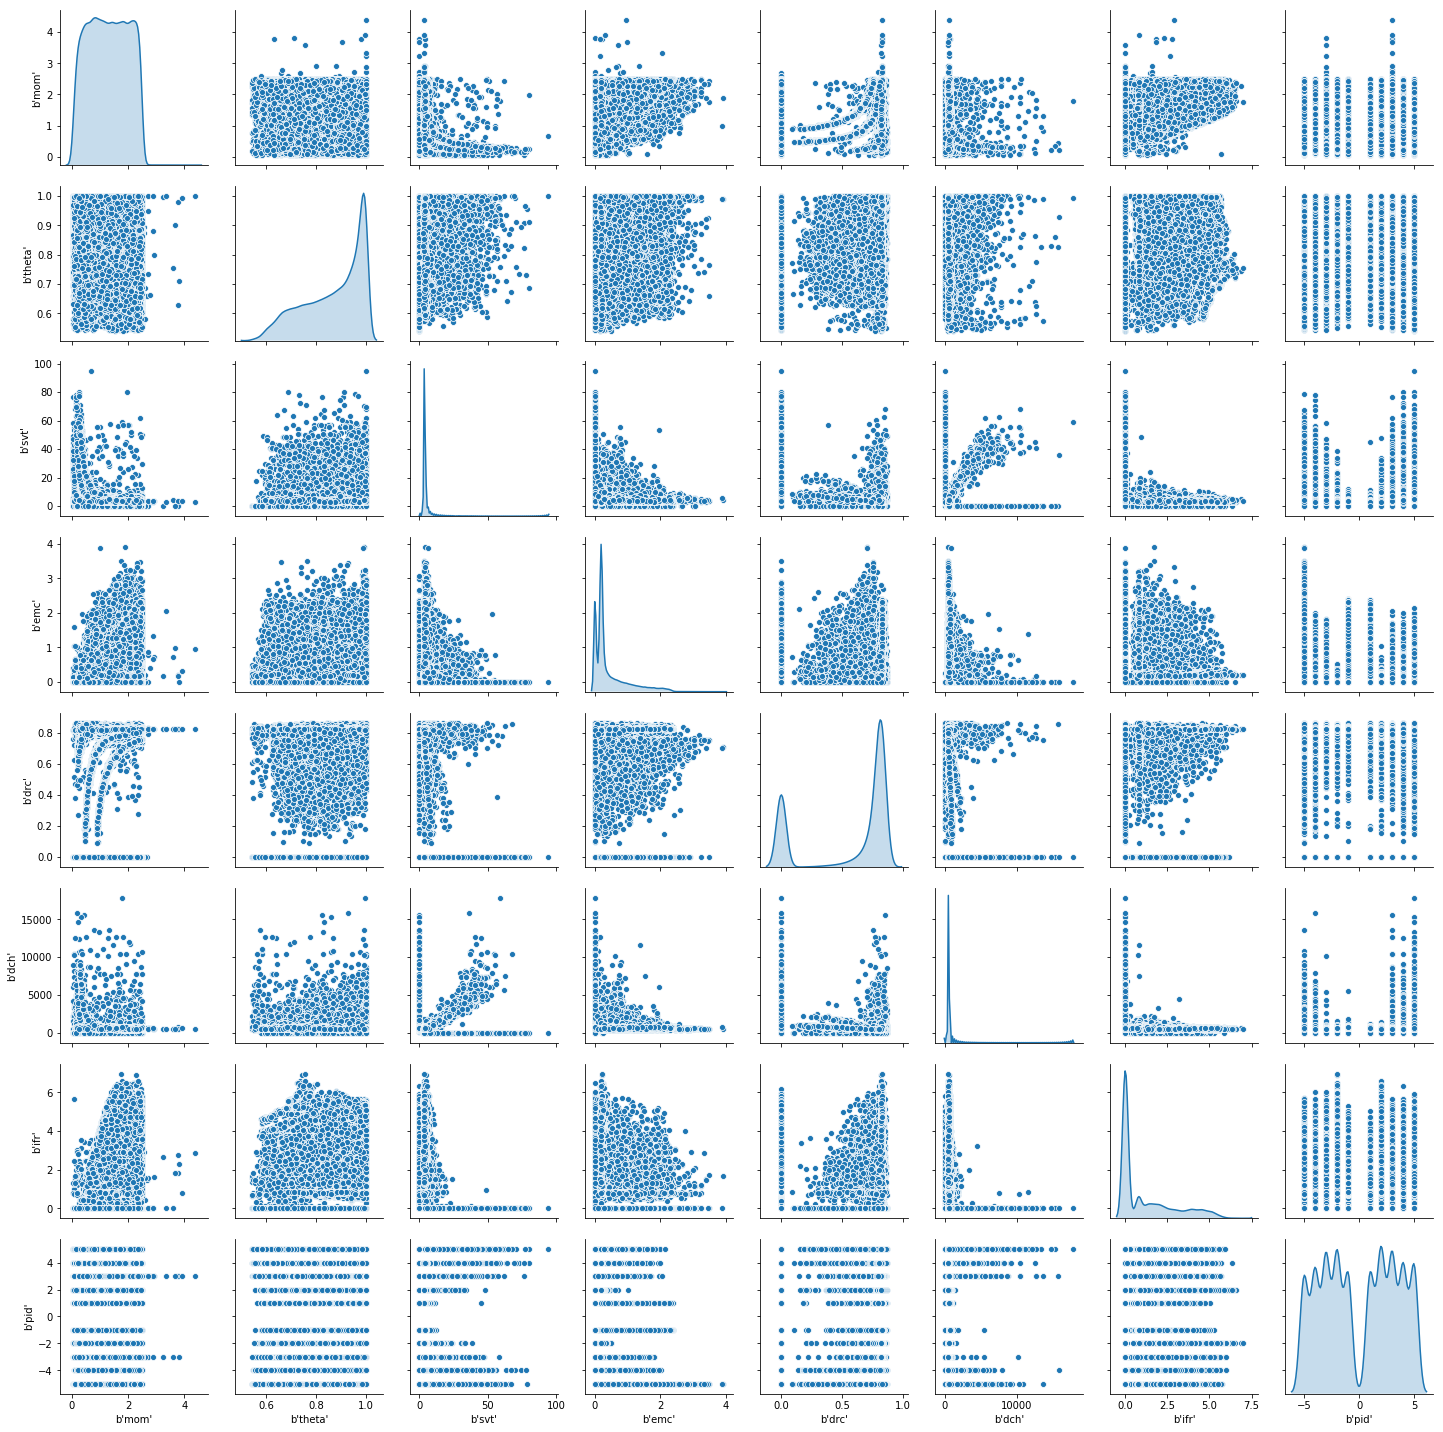

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(train_dataset[[b'mom', b'theta', b'svt', b'emc', b'drc', b'dch', b'ifr', b'pid']], diag_kind="kde")
plt.show()

In [23]:
train_stats = train_dataset.describe()
train_stats.pop(b'pid')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
b'mom',67061.0,1.307108,0.689137,0.050066,0.720330,1.304925,1.901470,4.373626
b'theta',67061.0,0.868312,0.117698,0.540726,0.778278,0.900298,0.974814,1.000000
b'svt',67061.0,4.892804,5.299843,0.000000,3.320312,3.759766,4.492188,94.531250
b'emc',67061.0,0.436656,0.535124,0.000000,0.150967,0.203514,0.564957,3.915405
b'drc',67061.0,0.571136,0.351391,0.000000,0.000000,0.792264,0.820829,0.864134
b'dch',67061.0,605.618286,578.292175,0.000000,473.632812,537.109375,634.765625,17812.500000
b'ifr',67061.0,1.168364,1.622137,0.000000,0.000000,0.000000,2.039216,6.980392


In [24]:
train_labels = train_dataset.pop(b'pid')
test_labels = test_dataset.pop(b'pid')

In [25]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [38]:
def build_model():
  model = keras.Sequential([
    layers.Dense(15, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
  ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
return model

TypeError: Input 'y' of 'Equal' Op has type float32 that does not match type int32 of argument 'x'.

In [31]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 10

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


..........

In [36]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
5,9.006019,2.649292,9.006021,8.847158,2.637786,8.847161,5
6,8.995975,2.645717,8.995979,8.866752,2.618372,8.866755,6
7,8.981713,2.643057,8.981709,8.834473,2.630134,8.834472,7
8,8.961305,2.637597,8.961302,8.835377,2.616197,8.835382,8
9,8.951506,2.636791,8.951505,8.832950,2.607506,8.832949,9


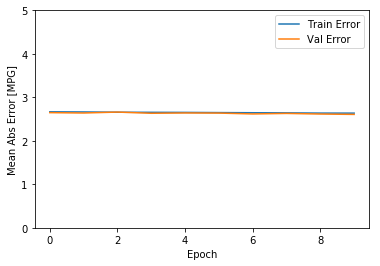

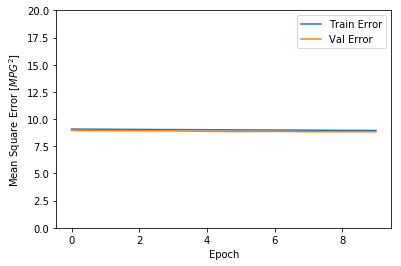

In [37]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [pid]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$pid^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)